In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import matplotlib.pylab as mplot
import yaml
import h5py
import healpy as hp
# import healsparse as hs
import scipy
from scipy import interpolate

%matplotlib inline

mplot.rc('text', usetex=True)
mplot.rc('font', family='serif')


# matplotlib.rcParams['font.family'] = "sans-serif"
# matplotlib.rcParams['font.sans-serif'] = "Times New Roman"


In [2]:
tag = '20240209'
project_dir = '/project/chihway/data/decade/'

In [3]:
with h5py.File(project_dir+'metacal_gold_combined_'+tag+'.hdf', 'r') as h5r:
    print(h5r.keys())

<KeysViewHDF5 ['Ag_planck13', 'Ag_sfd98', 'Ai_planck13', 'Ai_sfd98', 'Ar_planck13', 'Ar_sfd98', 'Az_planck13', 'Az_sfd98', 'BDF_FLUX_ERR_G', 'BDF_FLUX_ERR_G_DERED_PLANCK13', 'BDF_FLUX_ERR_G_DERED_SFD98', 'BDF_FLUX_ERR_I', 'BDF_FLUX_ERR_I_DERED_PLANCK13', 'BDF_FLUX_ERR_I_DERED_SFD98', 'BDF_FLUX_ERR_R', 'BDF_FLUX_ERR_R_DERED_PLANCK13', 'BDF_FLUX_ERR_R_DERED_SFD98', 'BDF_FLUX_ERR_Z', 'BDF_FLUX_ERR_Z_DERED_PLANCK13', 'BDF_FLUX_ERR_Z_DERED_SFD98', 'BDF_FLUX_G', 'BDF_FLUX_G_DERED_PLANCK13', 'BDF_FLUX_G_DERED_SFD98', 'BDF_FLUX_I', 'BDF_FLUX_I_DERED_PLANCK13', 'BDF_FLUX_I_DERED_SFD98', 'BDF_FLUX_R', 'BDF_FLUX_R_DERED_PLANCK13', 'BDF_FLUX_R_DERED_SFD98', 'BDF_FLUX_Z', 'BDF_FLUX_Z_DERED_PLANCK13', 'BDF_FLUX_Z_DERED_SFD98', 'BDF_S2N', 'BDF_T', 'COADD_OBJECT_ID', 'DEC', 'FLAGS_BAD_COLOR', 'FLAGS_FOOTPRINT', 'FLAGS_FOREGROUND', 'FLAGS_SG_BDF', 'FLUXERR_AUTO_G', 'FLUXERR_AUTO_G_DERED_PLANCK13', 'FLUXERR_AUTO_G_DERED_SFD98', 'FLUXERR_AUTO_I', 'FLUXERR_AUTO_I_DERED_PLANCK13', 'FLUXERR_AUTO_I_DERED_SFD

In [4]:
with h5py.File(project_dir+'metacal_gold_combined_'+tag+'.hdf', 'r') as h5r:
    flux_r, flux_i, flux_z = h5r['mcal_flux_noshear_dered_sfd98'][:].T
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:] 
    fg = h5r['FLAGS_FOREGROUND'][:] 
    bc = h5r['FLAGS_BAD_COLOR'][:] 
    ft = h5r['FLAGS_FOOTPRINT'][:] 
    T = h5r['mcal_T_noshear'][:]
    mcal_flags = h5r['mcal_flags'][:]
    g1, g2  = h5r['mcal_g_noshear'][:].T

mag_r = -2.5*np.log10(flux_r)+30
mag_i = -2.5*np.log10(flux_i)+30
mag_z = -2.5*np.log10(flux_z)+30

del flux_r, flux_i, flux_z

# PZ mask
mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

# Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
SNR_Mask   = (s2n > 10) & (s2n < 1000)
Tratio_Mask= size_ratio > 0.5
T_Mask = T < 10
Flag_Mask = (mcal_flags == 0)
mcal_cut = SNR_Mask*Tratio_Mask*T_Mask*Flag_Mask
mcal_cut = mcal_cut & np.invert((T > 2) & (s2n < 30)) 
binary_Mask = np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))

del s2n, T, size_ratio, mag_r, mag_i, mag_z, g1, g2

FG_Mask = (fg==0)
FT_Mask = (ft==0)
BC_Mask = (bc==0)

/scratch/local/jobs/20112741/ipykernel_4026781/2574887582.py:12: RuntimeWarning: invalid value encountered in log10
  mag_r = -2.5*np.log10(flux_r)+30
/scratch/local/jobs/20112741/ipykernel_4026781/2574887582.py:13: RuntimeWarning: invalid value encountered in log10
  mag_i = -2.5*np.log10(flux_i)+30
/scratch/local/jobs/20112741/ipykernel_4026781/2574887582.py:14: RuntimeWarning: invalid value encountered in log10
  mag_z = -2.5*np.log10(flux_z)+30
/scratch/local/jobs/20112741/ipykernel_4026781/2574887582.py:32: RuntimeWarning: invalid value encountered in log10
  binary_Mask = np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))


In [5]:
# mplot.hist(mag_i, bins=100, range=(15,28), label='Gold cuts')
# mplot.hist(mag_i[FG_Mask], bins=100, range=(15,28), label='+ Foreground mask')
# mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask], bins=100, range=(15,28), label='+ Mcal cuts')
# mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask], bins=100, range=(15,28), label='+ Star/Galaxy cut', histtype='step', lw=2)
# mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask*T_Mask*Other_Mask*mcal_pz_mask], bins=100, range=(15,28), label='+ Othres', histtype='step', lw=2)

# mplot.legend()
# mplot.xlim(15,26)
# mplot.yscale('log')
# mplot.xlabel('i mag')


In [35]:
# !echo $PATH

In [7]:
with h5py.File(project_dir+'metacal_gold_combined_'+tag+'.hdf', 'r') as h5r:
    flux_r, flux_i, flux_z = h5r['mcal_flux_noshear_dered_sfd98'][:].T
mag_i = -2.5*np.log10(flux_i)+30

/scratch/local/jobs/20112741/ipykernel_4026781/3887210661.py:3: RuntimeWarning: invalid value encountered in log10
  mag_i = -2.5*np.log10(flux_i)+30


107371478
0.15994783004714114


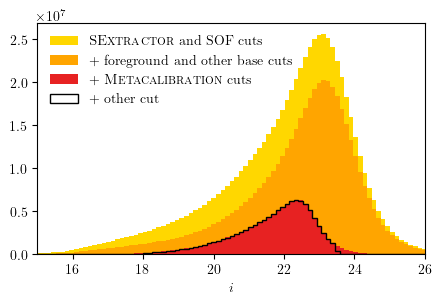

In [9]:
mplot.figure(figsize=(5,3))
mplot.hist(mag_i, bins=100, range=(15,28), label='\\textsc{SExtractor} and SOF cuts', color='gold')
mplot.hist(mag_i[FG_Mask*FT_Mask*BC_Mask], bins=100, range=(15,28), label='+ foreground and other base cuts', color='orange')
mplot.hist(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut], bins=100, range=(15,28), label='+ \\textsc{Metacalibration} cuts', color='#e72222')
# mplot.hist(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut*mcal_pz_mask], bins=100, range=(15,28), label='+ extreme color cuts', histtype='step', lw=1, color='w')
mplot.hist(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut*mcal_pz_mask*binary_Mask], bins=100, range=(15,28), label='+ other cut', histtype='step', lw=1, color='k') 

print(len(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut*mcal_pz_mask*binary_Mask]))
print(len(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut*mcal_pz_mask*binary_Mask])/len(mag_i))

mplot.legend(fontsize=10, frameon = False)
mplot.xlim(15,26)
mplot.xlabel('$i$')

mplot.savefig('mag_dist_cuts.pdf', bbox_inches='tight')


In [45]:
N = len(mag_i)
print(len(mag_i))
print(len(mag_i[FG_Mask*FT_Mask*BC_Mask]), len(mag_i[FG_Mask*FT_Mask*BC_Mask])/N*100)
print(len(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut]), len(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut])/N*100)
print(len(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut*mcal_pz_mask*binary_Mask]), len(mag_i[FG_Mask*FT_Mask*BC_Mask*mcal_cut*mcal_pz_mask*binary_Mask])/N*100)


671290620
470812637 70.13544104042448
111400589 16.594986684008784
107371478 15.994783004714114


In [46]:
N = len(mag_i)
print(len(mag_i))
print(len(mag_i[FG_Mask*FT_Mask*BC_Mask]), len(mag_i[FG_Mask*FT_Mask*BC_Mask])/N*100)
print(len(mag_i[mcal_cut]), len(mag_i[mcal_cut])/N*100)
print(len(mag_i[mcal_pz_mask*binary_Mask]), len(mag_i[mcal_pz_mask*binary_Mask])/N*100)


671290620
470812637 70.13544104042448
140432055 20.91971060164672
480429730 71.56806838742958


In [8]:
print(len(mag_i))
print(len(mag_i[FG_Mask]))
print(len(mag_i[SNR_Mask*Tratio_Mask]))
print(len(mag_i[SG_Mask]))
print(len(mag_i[T_Mask*Other_Mask*mcal_pz_mask]))


244200019
196160670
59938572
146535714
163033587


In [9]:
49586959/49841218

0.9948986198531504

In [10]:
163033587/244200019

0.6676231544437349

In [11]:
49841218/244200019

0.2040999759299773

In [12]:
# should probably code this up...

Text(0, 0.5, 'r')

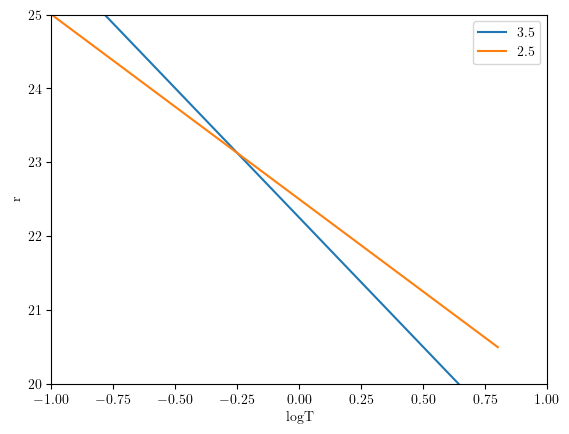

In [3]:
logT = np.arange(10)/10*2-1
r_35 = 22.25-(logT*3.5)
r_25 = 22.5-(logT*2.5)

mplot.plot(logT, r_35, label='3.5')
mplot.plot(logT, r_25, label='2.5')
mplot.legend()
mplot.xlim(-1,1)
mplot.ylim(20,25)
mplot.xlabel('logT')
mplot.ylabel('r')


In [7]:
with h5py.File(project_dir+'metacal_gold_combined_'+tag+'.hdf', 'r') as h5r:
    mask = h5r['baseline_mcal_mask_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:] 
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    ra = h5r['RA'][:]

In [8]:
len(ra[mask>0])

107371478

In [13]:
len(ra[(mask>0)*(s2n>=10)*(s2n<=400)*(size_ratio>=0.5)*(size_ratio<=6)])

104610038

In [10]:
104610038/107371478

0.9742814381301522